In [91]:
%pip install numpy scipy matplotlib ipympl sounddevice IPython
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [92]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio

# Cargar el archivo WAV
fs, data = wavfile.read('mtms-arrC1A.wav')

data = np.swapaxes(data,0,1)

#imprimir información del archivo
print(f'Tasa de muestreo: {fs} Hz')
print(f'Duración: {data.shape[1] / fs:.2f} segundos')
print(f'Número de canales: {data.shape[0] if data.ndim > 1 else 1}')
print(f'Número de muestras: {data.shape[1]}')

Tasa de muestreo: 16000 Hz
Duración: 33.97 segundos
Número de canales: 15
Número de muestras: 543489


In [93]:
# Spectrogram
def plot_spectrogram(data, sample_rate, vmin=-20, vmax=10, NFFT=1024, noverlap=512):
    plt.figure(figsize=(10, 6))
    plt.specgram(data, Fs=sample_rate, NFFT=NFFT, noverlap=noverlap, cmap='plasma', sides='twosided', vmin=vmin, vmax=vmax)
    plt.title('Espectrograma de mtms-arrC1A.wav')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Frecuencia [Hz]')
    plt.colorbar(label='Intensidad [dB]')
    plt.show()

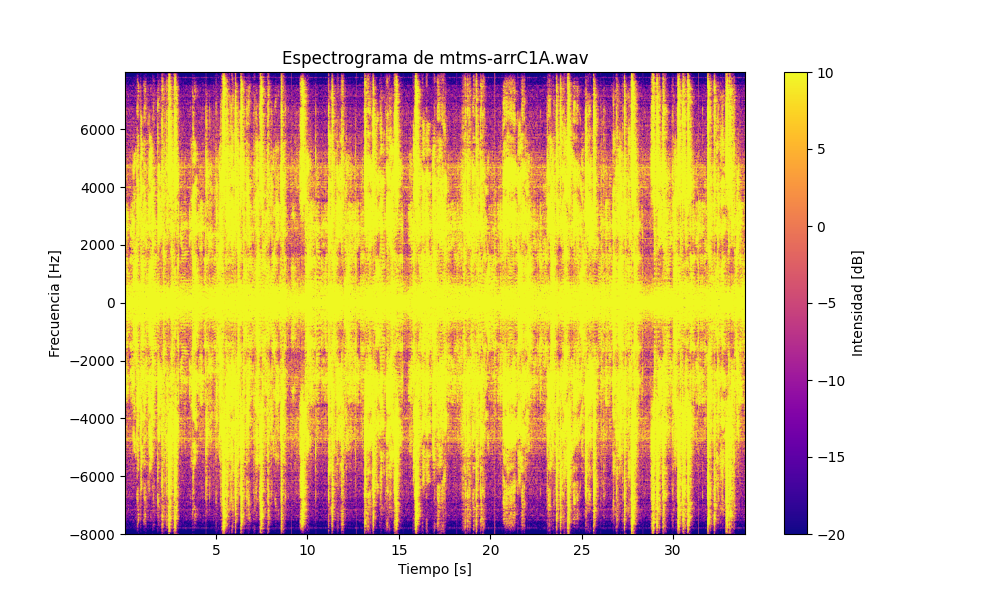

In [94]:
plot_spectrogram(data[0], fs)

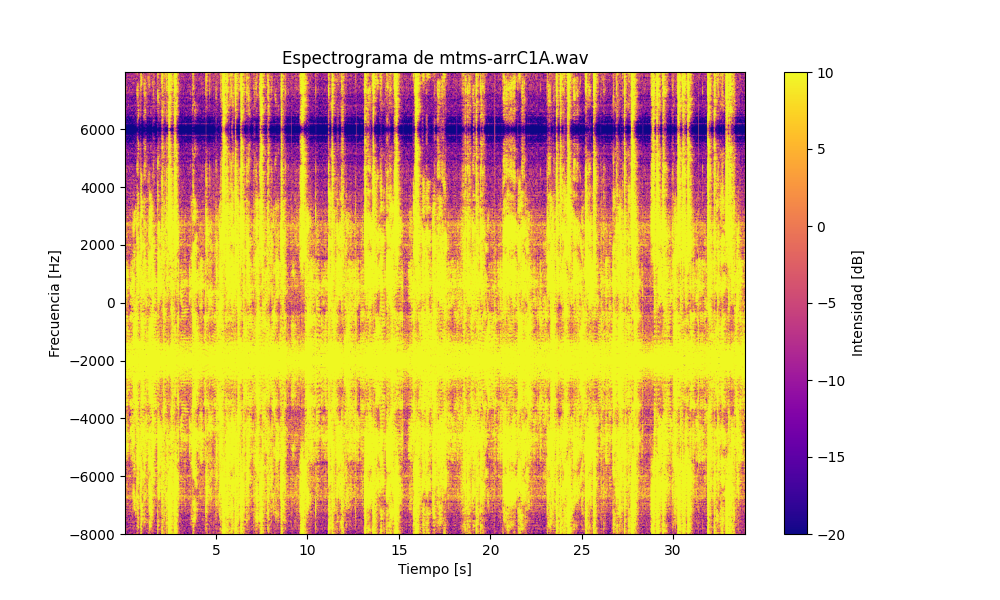

In [95]:
# Modulate 2KHz -> 0Hz

time = np.linspace(0, len(data[0])/fs, len(data[0]))
carrier_freq = 2000
modulated_signals = data * (np.exp(-2j * np.pi * carrier_freq * time))
plot_spectrogram(modulated_signals[0], fs)

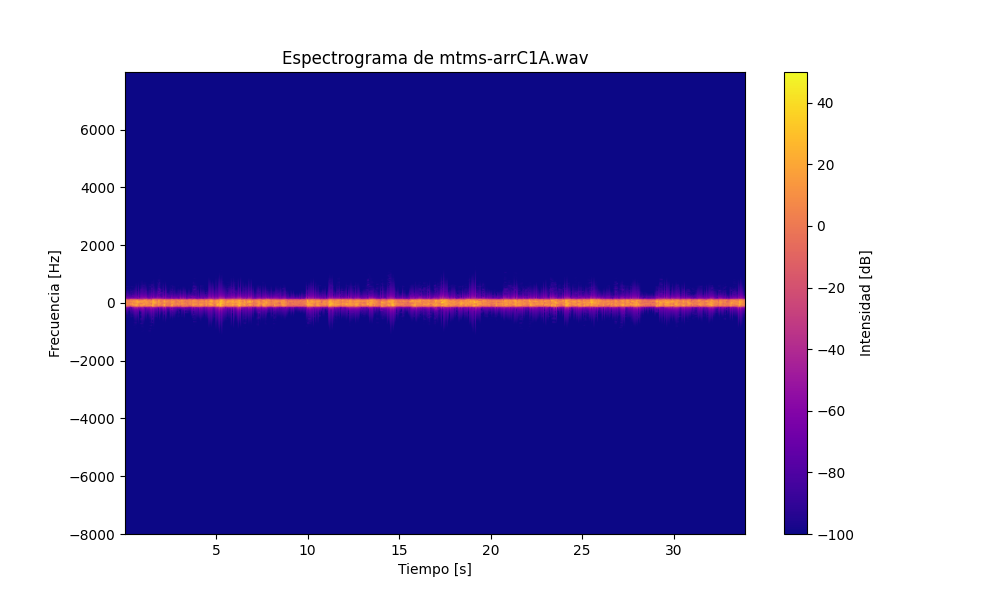

In [96]:
import scipy.signal as sp
# Apply low pass filter
h_c = sp.firwin(numtaps=1000, cutoff=100, fs=fs, window='blackman')
filtered_signals = sp.lfilter(h_c, 1.0, modulated_signals)
plot_spectrogram(filtered_signals[0], fs, vmin=-100, vmax=50, NFFT=2048, noverlap=1024)


In [97]:
speed_of_sound = 343  # m/s
lamda = speed_of_sound / 2000  # Longitud de onda para 2 kHz
d_max = lamda / 2  # Distancia entre micrófonos
print(d_max)

0.08575


In order to not have alias, the spatial resolution has to be better than 8.575 cm. That is why we choose the ULA with 8cm spacing between sensors

In [98]:
ula = [filtered_signals[1], filtered_signals[2], filtered_signals[3], filtered_signals[5], filtered_signals[7], filtered_signals[9], filtered_signals[11], filtered_signals[12], filtered_signals[13]]

d = 0.08
M = len(ula)
# Insert zero padding in between sensors
zero_padding = 0
ula_padded = []
for signal in range(0, len(ula)-1):
    ula_padded.append(ula[signal])
    for _ in range(0, zero_padding):
        ula_padded.append(np.zeros_like(ula[signal]))
ula_padded.append(ula[-1])

instant_lenght = len(ula)
# flatten the list
ula_padded = np.swapaxes(ula_padded, 0, 1)
flattened_ula = np.array(ula_padded).flatten()
instant_samples = []
for i in range(0, len(ula[0])):
    start = i * instant_lenght
    instant = flattened_ula[start:start + instant_lenght]
    instant_samples.append(instant)
print(len(instant_samples))
instant_samples = np.array(instant_samples)

543489


In [99]:
def plot_spatial_spectogram(instant_samples, d, fft_size, beamformer=None, vmin=25, vmax=75):
    # data: shape (N_samples, N_sensors)
    N, _ = instant_samples.shape

    fft_size = 128

    # Spatial FFT across sensor axis
    fft = np.fft.fft(instant_samples, axis=1, n=fft_size)
    spatial_fft = np.fft.fftshift(fft, axes=1)

    if beamformer is not None:
        Bf = np.fft.fftshift(np.fft.fft(beamformer, n=fft_size))
        spatial_fft = spatial_fft * np.conj(Bf)

    # Spatial frequency axis (cycles per sensor)
    spatial_freqs = np.fft.fftshift(np.fft.fftfreq(fft_size))  # range -0.5 ... +0.5

    # Convert spatial frequency to angle
    # spatial_freq = (d / λ) * sin(theta)
    wavelength = lamda
    sin_theta = spatial_freqs * wavelength / d
    sin_theta = np.clip(sin_theta, -1, 1)  # Limit to valid range for arcsin
    angles = np.arcsin(sin_theta) * 180 / np.pi

    # Plot spatial-angle spectrogram
    plt.figure(figsize=(12, 6))
    plt.imshow(
        20 * np.log10(np.abs(spatial_fft) + 1e-10),
        aspect='auto',
        origin='lower',
        extent=[angles[0], angles[-1], 0, N],
        cmap='inferno',
        vmin=vmin,
        vmax=vmax
    )
    plt.colorbar(label="Magnitude (dB)")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Time (samples)")
    plt.title("Spatial Angle Spectrogram (ULA)")
    plt.show()
    return spatial_fft

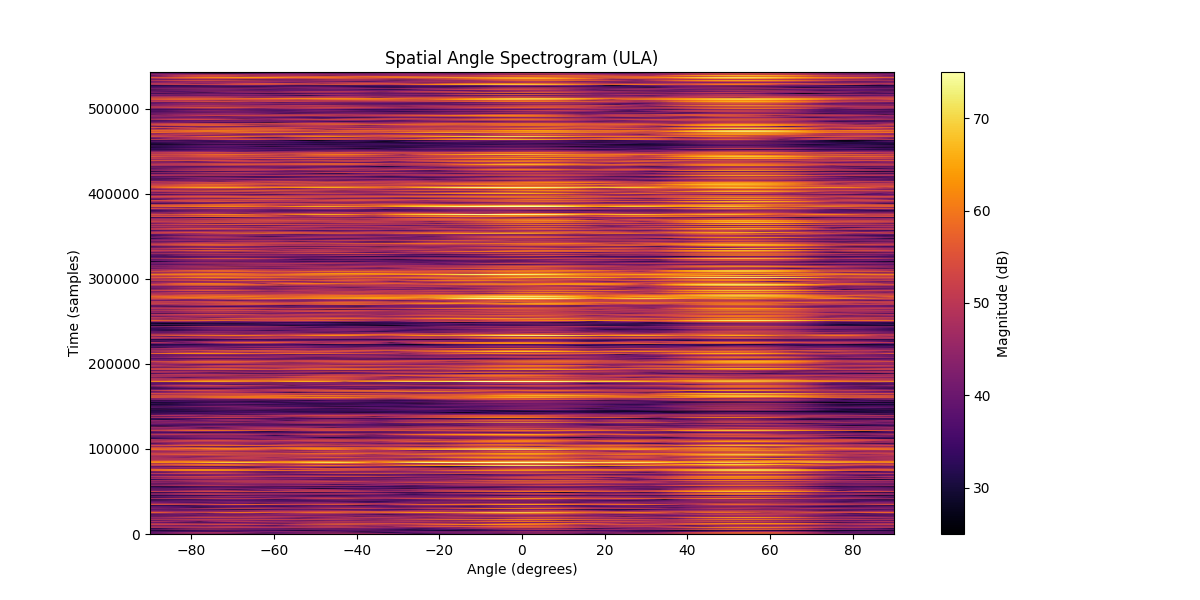

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 4.52441745e-18-4.52443053e-18j,  4.31921461e-18-4.86738124e-18j,
         4.14006586e-18-5.41600985e-18j, ...,
         6.17989747e-18-3.85390824e-18j,  5.41599788e-18-4.14008152e-18j,
         4.86736876e-18-4.31922868e-18j],
       [-1.11464201e-06+1.11464523e-06j, -1.06408794e-06+1.19913506e-06j,
        -1.01995260e-06+1.33429600e-06j, ...,
        -1.52248845e-06+9.49454392e-07j, -1.33429305e-06+1.01995645e-06j,
        -1.19913199e-06+1.06409140e-06j],
       ...,
       [ 4.92504462e+01+3.07842734e+01j,  6.04771779e+01+2.46441435e+01j,
         6.97655857e+01+1.15045983e+01j, ...,
         3.23951545e+01+1.67495185e+01j,  3.30548132e+01+2.47974400e+01j,
         3.92335655e+01+3.03043486e+01j],
       [ 4.94464501e+01+3.39784054e+01j,  6.

In [100]:
plot_spatial_spectogram(instant_samples, d, 128)

In [ ]:
# Array response
u = lambda Phi: d*np.sin(Phi)/lamda
def V(phi):
    i = np.arange(M)
    return (1/np.sqrt(M)) * np.exp(2j * np.pi * u(phi) * i)

zero = V(np.pi/4)

[ 0.33333333+0.j         -0.16030134+0.29225775j -0.17915421-0.28109586j
  0.33261331-0.02189748j -0.14075595+0.30215703j -0.1972331 -0.26871959j
  0.33045633-0.04370037j -0.12060247+0.31075095j -0.21445991-0.2551824j ]


In [116]:
def plot_beamformer(Cbm, Nfft=1024):
    plt.figure()
    ax = plt.subplot(projection='polar')
    fft = np.fft.fftshift(np.fft.fft(Cbm, n=Nfft))
    angles = np.arcsin(np.clip((lamda * np.fft.fftshift( np.fft.fftfreq(Nfft))/d),-1, 1))
    ax.plot(angles, 10*np.log10(np.abs(fft * np.conj(fft))))
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_thetamax(90)
    ax.set_thetamin(-90)
    plt.show()

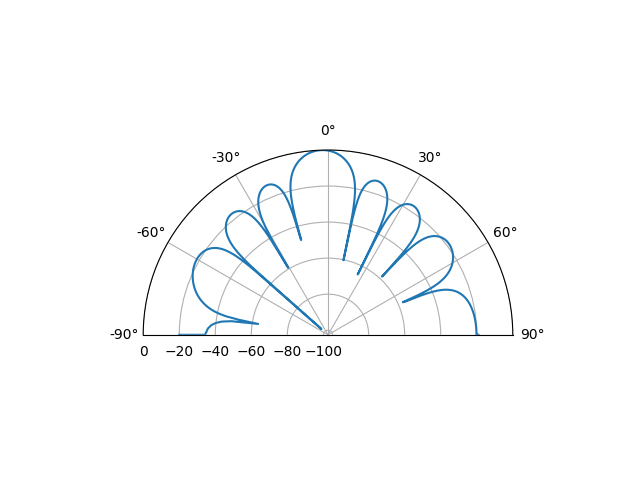

In [117]:
# Standard beamformer
C = 1 / np.sqrt(np.ones(M) * M)
Cbm = C * V(np.deg2rad(-2))
plot_beamformer(Cbm, 1024)

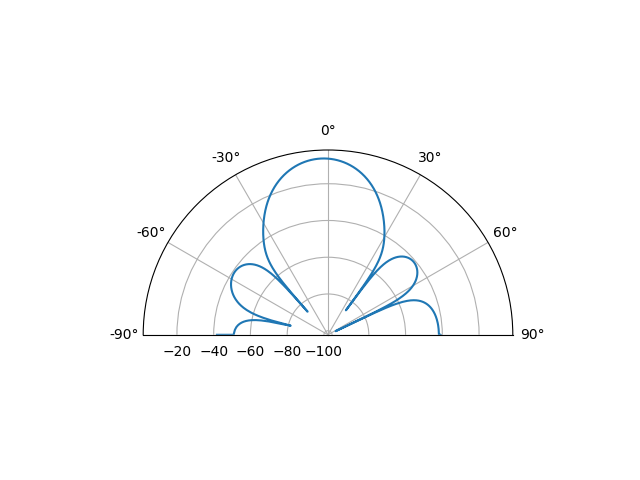

In [118]:
# Taper Beamformer
h_win = sp.windows.hamming(len(C))
Cbmt = Cbm * h_win
plot_beamformer(Cbmt)

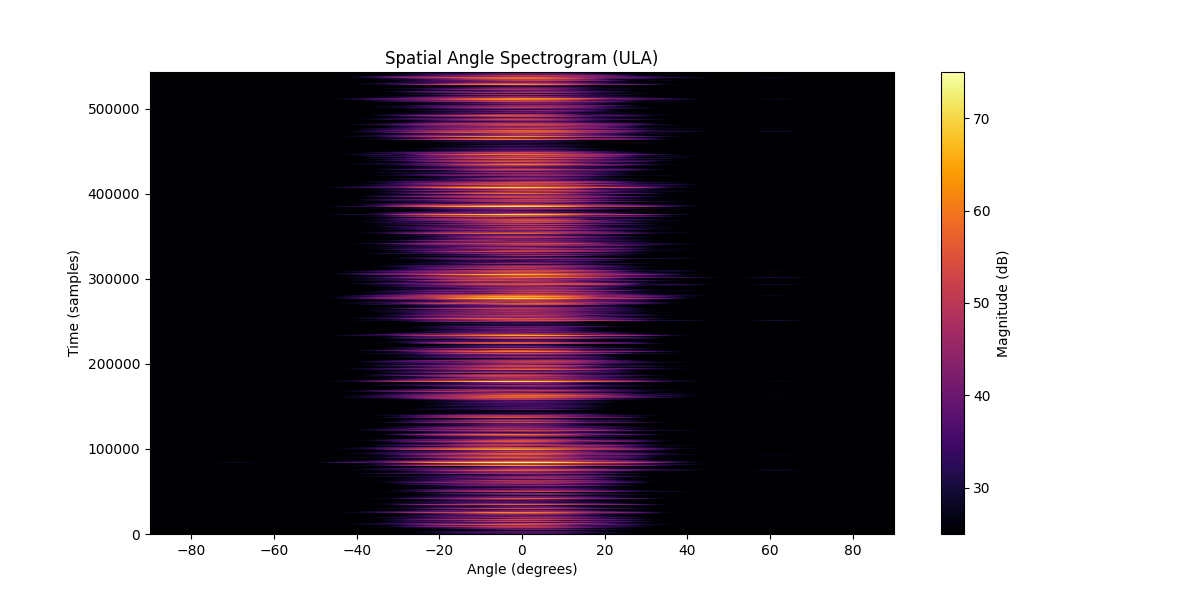

In [119]:
spatial_fft = plot_spatial_spectogram(instant_samples, d, 32, Cbmt)

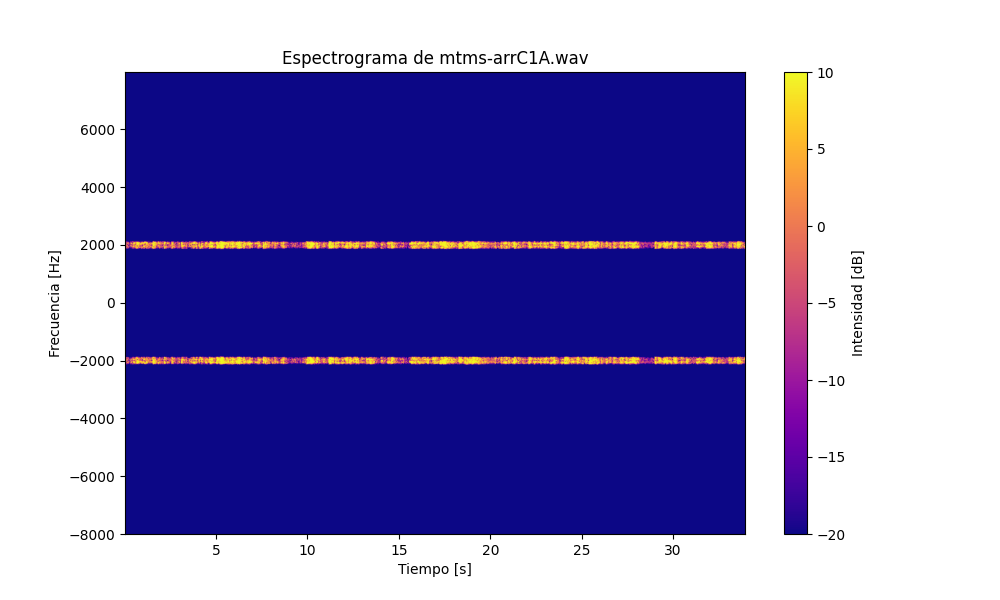

In [106]:
spatial_filtered_data = np.fft.ifft(spatial_fft)
result = np.sum(spatial_filtered_data, axis=1)
result *= np.exp(2j * np.pi * carrier_freq * time)
result = 2*result.real
result /= np.max(result)
result *= 2**10
plot_spectrogram(result, fs)

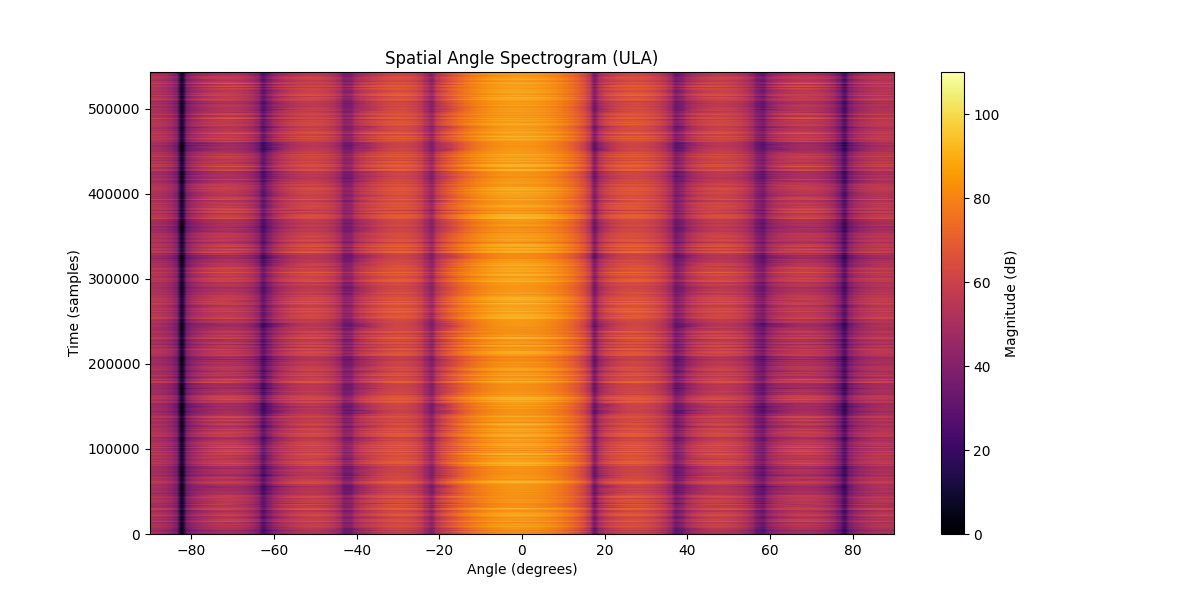

In [108]:
ula_raw = [data[1], data[2], data[3], data[5], data[7], data[9], data[11], data[12], data[13]]
ula_raw = np.swapaxes(np.array(ula_raw), 0, 1)

Result = plot_spatial_spectogram(ula_raw, d, 9, vmin=0, vmax=110, beamformer=Cbm)

In [109]:
def apply_beamformer(input_data, Cbm, fs=16000):
    input_data = np.asarray(input_data)       # shape: (N, M)

    # Weight vector
    w = np.conj(Cbm).reshape(-1)              # shape: (M,)

    # Apply beamformer
    result = input_data @ w                   # (N,)
    result = np.real(result)                  # ensure real audio

    # Normalize safely
    peak = np.max(np.abs(result))
    if peak > 0:
        result_n = (result / peak * 32767).astype(np.int16)
    else:
        result_n = result.astype(np.int16)

    # Plot
    plt.figure()
    plt.plot(result_n)

    # Listen
    display(Audio(result_n, rate=fs))

    # Save wav
    wavfile.write("beamformer_output.wav", fs, result_n)

    return result_n

In [110]:
# Optimal beamformer
# load data
# Cargar el archivo WAV
fs2, data_noise = wavfile.read('noise_and_interference.wav')

data_noise = np.swapaxes(data_noise,0,1)

#imprimir información del archivo
print(f'Tasa de muestreo: {fs2} Hz')
print(f'Duración: {data_noise.shape[1] / fs:.2f} segundos')
print(f'Número de canales: {data_noise.shape[0] if data_noise.ndim > 1 else 1}')
print(f'Número de muestras: {data_noise.shape[1]}')

noise_ula = [data_noise[1], data_noise[2], data_noise[3], data_noise[5], data_noise[7], data_noise[9], data_noise[11], data_noise[12], data_noise[13]]


Tasa de muestreo: 16000 Hz
Duración: 0.82 segundos
Número de canales: 15
Número de muestras: 13161


C:\Users\jtori\AppData\Local\Temp\ipykernel_20284\912178839.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs2, data_noise = wavfile.read('noise_and_interference.wav')


In [111]:
time = np.linspace(0, len(noise_ula[0])/fs, len(noise_ula[0]))
noise_bb = noise_ula * (np.exp(-2j * np.pi * carrier_freq * time))

noise_bb_narrowband = sp.lfilter(h_c, 1.0, noise_bb)

In [112]:
R = np.zeros(shape=[len(noise_bb_narrowband), len(noise_bb_narrowband)], dtype=np.complex128)

for signal in np.array(noise_bb_narrowband).T:
    R += np.outer(np.conjugate(signal), signal)
R /= len(noise_bb_narrowband)
R_inv = np.linalg.inv(R)

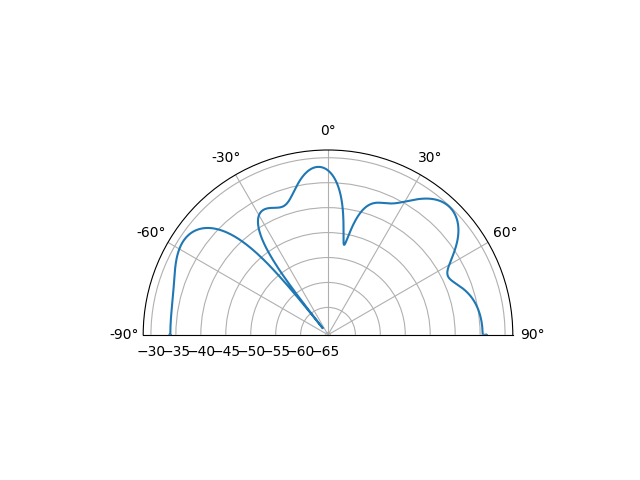

In [120]:
angle = -2
V_phi = V(np.deg2rad(angle))
Copt = (R_inv @ V_phi) / ((np.conjugate(V_phi) @ R_inv) @ R_inv)

plot_beamformer(Copt)